In [1]:
import numpy as np
import matplotlib.pyplot as plt

from simulation import *

from ipywidgets import interact, interactive, fixed, interact_manual,VBox
import ipywidgets as widgets

#from importlib import reload
#reload(simulation)

# Overview

There are four sections in this notebook

### 1. Simple interactive simulation
Simulate bias triangles with a total of 3 potential levels and few parameters

### 2. Complicated interactive simulation
Simulate bias triangles with a total of 5 potential levels. Also lets you control tunnel coupling between individual levels and drain/source tunneling rates.

### 3. Single random simulation
Draw random parameters and simulate a pair of bias triangles

### 4. Multiple random samples
This is how the simulation can be used in the training of a the Viola Jones algorithm

# 1. Simple interactive simulation
For widgets to work you need to run 
```
jupyter nbextension enable --py --sys-prefix widgetsnbextension
```
before starting the notebook. You can also run the cell below.

The simulation shows you the bias triangles on the left. On the right you can see how the potential levels align on the right. This reflects the situation at the red star in the left image.


### Noise
There are 4 elements of noise added:
- Gaussian blurring
- White noise
- Random charge jumps (between 0 and 2). Location and strength are also random
- Random jittering of potential levels at each pixel

In [2]:
! jupyter nbextension enable --py --sys-prefix widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [13]:
def plot_bias_triangle(
    x=50, y=50, charging=0.5, leverleft=0.9, leverright=1.2, crosslr=0.2, crossrl=0.3,
    mu_s=0, mu_d=-1, temp=0.1, gamma_s=0.1, gamma_d=0.1,
    tc=0.05, shift=1, blank_space=0.3, gaussian_blur=0.1, 
    jitter_var=0.01, in_psb=False, temp_broadening=True, adjust_voltage_window=True):

    params={}
    params['voltage_bounds']=[[-3,1],[-3,1]]
    params['n_points']=[100,100]
    params['dot1_pot_arrangement']=np.array([0.0])
    params['dot2_pot_arrangement']=np.array([0.0,charging])
    
    params['lever_arms']=[leverleft,leverright]
    params['cross_talk']=[crosslr,crossrl]
    params['mu_s']=mu_s
    params['mu_d']=mu_d
    params['temp']=temp
    params['gamma_s']=gamma_s
    params['gamma_d']=gamma_d
    params['tc']= tc
    params['jitter_var']=jitter_var
    params['shift']=shift
    params['temp_broadening']=temp_broadening
    params['gaussian_blur']=1
    params['gaussian_blur']=gaussian_blur
    params['white_noise_level']=5E-2

    params['in_psb']=in_psb

    current=get_bias_triangles(params, blank_space=blank_space, adjust_voltage_window=adjust_voltage_window)
    
    temp=params['temp']
    kT = 8.617E-5*temp*1E3
    n_points=params['n_points']
    params['blank_space'] = blank_space
    if adjust_voltage_window:
        voltage_bounds=get_voltage_extent(kT=kT, **params)
    else:
        voltage_bounds=params['voltage_bounds']
    dot1_voltages=np.linspace(voltage_bounds[0][0],voltage_bounds[0][1], n_points[0])
    dot2_voltages=np.linspace(voltage_bounds[1][0],voltage_bounds[1][1], n_points[1])
    
    labels=[]
    potlevels=[]
    
    labels.append('source pot')
    potlevels.append(mu_s)
    
    dot1_pot_arrangement=params['dot1_pot_arrangement']
    dot2_pot_arrangement=params['dot2_pot_arrangement']
    
    dot1_base,dot2_base=get_base_pots(params, adjust_voltage_window=adjust_voltage_window, blank_space=blank_space)
    dot1_base +=params['shift']
    dot2_base +=params['shift']
    dot1_pots=(dot1_base[:,:,np.newaxis]+dot1_pot_arrangement[np.newaxis,:])
    dot2_pots=(dot2_base[:,:,np.newaxis]+dot2_pot_arrangement[np.newaxis,:])
    potential_levels0=dot1_pots[y,x]
    potential_levels1=dot2_pots[y,x]
    
    for val in potential_levels0:
        labels.append('leftdot')
        potlevels.append(val)
    for val in potential_levels1:
        labels.append('rightdot')
        potlevels.append(val)

    labels.append('drain pot')
    potlevels.append(mu_d)
        
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
    ax1.imshow(current[:,:], origin='lower',extent=(*voltage_bounds[0],*voltage_bounds[1]))
    ax1.scatter(dot1_voltages[x],dot2_voltages[y],s=200, c='tab:red',marker='*')
    ax2.scatter(labels,potlevels, marker='_')
    
    return()

ip=interact(
    plot_bias_triangle, x=(1,100,1), y=(1,100,1), charging=(0.1,2,0.1,),
    leverleft=(0,2,0.1), leverright=(0,2,0.1), crosslr=(0,1,0.1), crossrl=(0,1,0.1),
    mu_s=(0,1,0.1), mu_d=(-1,0,0.1), temp=(0.01,2,0.1), 
    gamma_s=(0,1,0.1), gamma_d=(0,1,0.1),
    tc=(0,0.5,0.01), 
    blank_space=(0,1,0.1), shift=(0,1,0.1),
    gaussian_blur=(0,10,1), jitter_var=(0,.1,0.01)
)


interactive(children=(IntSlider(value=50, description='x', min=1), IntSlider(value=50, description='y', min=1)…

# Complicated interactive simulation

We added more potential levels (there are now 2 in the left dot and 3 in the right).
Here you get more control over the tunneling rates from the source and to the drain. You can also control the tunnel-coupling between each level.

In [15]:
def plot_bias_triangle(
    x=50, y=50,charging=0.4,leverleft=0.9,leverright=1.2, crosslr=0.2,crossrl=0.3,
    mu_s=0, mu_d=-1, temp=0.1, gamma_s=0.1, gamma_s2=0.3, gamma_d=0.1, gamma_d2=0.4,
    tc11=0.02, tc12=0.11, tc13=0.05, 
    tc21=0.05, tc22=0.05, tc23=0.05,
    jitter_var=0.01,shift=1,blank_space=0.3, temp_broadening=True, in_psb=False):
    
    params={}
    params['voltage_bounds']=[[-3,3],[-3,3]]
    params['n_points']=[100,100]
    params['dot1_pot_arrangement']=np.array([0.0, 2*charging])#,1.5])
    params['dot2_pot_arrangement']=np.array([0.0,charging,2*charging])
    
    params['lever_arms']=[leverleft,leverright]
    params['cross_talk']=[crosslr,crossrl]
    params['mu_s']=mu_s
    params['mu_d']=mu_d
    params['temp']=temp
    params['gamma_s']=[gamma_s, gamma_s2]
    params['gamma_d']=[gamma_d,gamma_d2,gamma_d2]
    params['tc']= np.array([[tc11,tc12,tc13],
                            [tc21,tc22,tc23]])
    params['jitter_var']=jitter_var
    params['shift']=shift
    params['temp_broadening']=temp_broadening
    params['gaussian_blur']=1
    params['white_noise_level']=5E-2
    params['in_psb']=in_psb
    
    #print(blank_space)
    current=get_bias_triangles(params, blank_space=blank_space)
    
    temp=params['temp']
    kT = 8.617E-5*temp*1E3
    n_points=params['n_points']
    params['blank_space'] = blank_space
    voltage_bounds=get_voltage_extent(kT=kT ,**params)
    dot1_voltages=np.linspace(voltage_bounds[0][0],voltage_bounds[0][1], n_points[0])
    dot2_voltages=np.linspace(voltage_bounds[1][0],voltage_bounds[1][1], n_points[1])
    
    labels=[]
    potlevels=[]
    
    labels.append('source pot')
    potlevels.append(mu_s)
    
    dot1_pot_arrangement=params['dot1_pot_arrangement']
    dot2_pot_arrangement=params['dot2_pot_arrangement']
    
    
    dot1_base,dot2_base=get_base_pots(params, adjust_voltage_window=True, blank_space=blank_space)
    dot1_base +=params['shift']
    dot2_base +=params['shift']
    dot1_pots=(dot1_base[:,:,np.newaxis]+dot1_pot_arrangement[np.newaxis,:])
    dot2_pots=(dot2_base[:,:,np.newaxis]+dot2_pot_arrangement[np.newaxis,:])
    potential_levels0=dot1_pots[y,x]
    potential_levels1=dot2_pots[y,x]
    
    for val in potential_levels0:
        labels.append('leftdot')
        potlevels.append(val)


    for val in potential_levels1:
        labels.append('rightdot')
        potlevels.append(val)


    labels.append('drain pot')
    potlevels.append(mu_d)
        
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
    ax1.imshow(current[:,:], origin='lower',extent=(*voltage_bounds[0],*voltage_bounds[1]))
    ax1.scatter(dot1_voltages[x],dot2_voltages[y],s=200, c='tab:red',marker='*')
    ax2.scatter(labels,potlevels, marker='_')
    
    return()

ip=interact(
    plot_bias_triangle, x=(1,100,1), y=(1,100,1), charging=(0.1,2,0.1,),
    leverleft=(0,2,0.1),leverright=(0,2,0.1), crosslr=(-1,1,0.1), crossrl=(-1,1,0.1),
    mu_s=(0,1,0.1), mu_d=(-1,0,0.1), temp=(0.01,2,0.01), 
    gamma_s=(0,1,0.1), gamma_s2=(0,1,0.1), gamma_d=(0,1,0.1), gamma_d2=(0,1,0.1), 
    tc11=(0,0.5,0.01), tc12=(0,0.5,0.01), tc13=(0,0.5,0.01), 
    tc21=(0,0.5,0.01), tc22=(0,0.5,0.01), tc23=(0,0.5,0.01),
    jitter_var=(0,1,0.01),blank_space=(0,1,0.1),shift=(0,1,0.1)
)

interactive(children=(IntSlider(value=50, description='x', min=1), IntSlider(value=50, description='y', min=1)…

# Single random sample

Now we sample random parameters and simulate accordingly

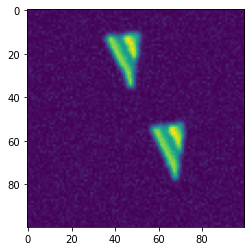

{'tc': array([[0.06655145, 0.02530253, 0.02507853, 0.19690298, 0.09748407],
       [0.2312176 , 0.3885961 , 0.34904925, 0.17529284, 0.07370368]]), 'gamma_s': array([0.2923151 , 0.09527688]), 'gamma_d': array([0.09102205, 0.3426824 , 0.41970079, 0.48708984, 0.31328656]), 'mu_s': 0.443047308788747, 'mu_d': -0.23881637638660247, 'temp': 0.23363671782879888, 'lever_arms': array([1.49858399, 0.90324283]), 'cross_talk': array([0.20909864, 0.10284197]), 'shift': 0.8648680460541563, 'dot1_pot_arrangement': array([ 0.        , -0.82599738]), 'dot2_pot_arrangement': array([0.        , 0.19920118, 0.44425719, 0.72632309, 0.94991708]), 'in_psb': True, 'jitter_var': 0.023390239871891285, 'gaussian_blur': 0.99712359515413, 'white_noise_level': 0.038786400644909624, 'n_points': [100, 100], 'blank_space': 0.3}


In [16]:
params = standard_sample_factors()
params['n_points'] = [100, 100]
current = get_bias_triangles(params, blank_space=0.3)
plt.imshow(current)
plt.show()
print(params)

# Multiple random samples

Here you can sample the training data for. 

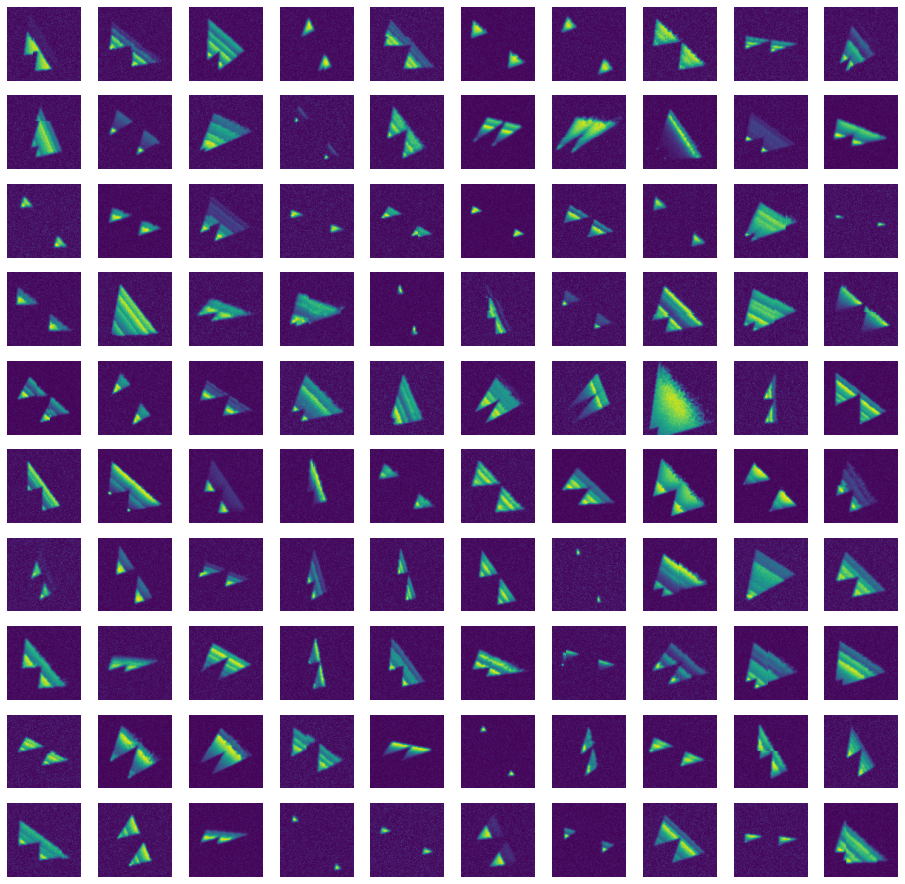

In [18]:
n_samples=100
samples=simulate_for_viola_jones(n_samples)

fig=plt.figure(figsize=(16,16))


for i, sample in enumerate(samples):
    plt.subplot(10, 10, i+1)
    plt.imshow(sample)
    plt.clim(0,1)
    plt.axis('off')
    
plt.show()

## We can give the sampler a function that defines the way and range of values.
## Especially, for the Viola Jones, we want to minimise the blank space around the triangles:

In [19]:
def sample_factors():
    
    mu_s = np.random.uniform(-0.5, 0.5)
    bias = np.random.uniform(-2,-0.1)
    mu_d = mu_s + bias
    temp = np.random.uniform(0.1, 1)
    shift = np.random.uniform(0.01, 2)
    
    lever_arms = np.random.uniform(0.5, 1.5, 2)
    cross_talk = np.random.uniform(0.0, 0.5, 2)
    
    n_pots_1 = np.random.randint(2, 4)
    n_pots_2 = np.random.randint(2, 7)
    
    charging1 = np.random.uniform(bias - 0.2, bias + 0.2)
    epsilon = charging1 / 4
    charging11_deltas = np.array([0] + [*np.random.uniform(-epsilon, epsilon, n_pots_1 - 1)])
    
    charging2 = np.random.uniform(0.2, 0.5)
    epsilon = charging2 / 4
    charging21_deltas = np.array([0] + [*np.random.uniform(-epsilon, epsilon, n_pots_2 - 1)])
    
    dot1_pot_arrangement = charging11_deltas+[i*charging1 for i in range(n_pots_1)]
    
    dot2_pot_arrangement = charging21_deltas+[i*charging2 for i in range(n_pots_2)]
    
    gamma_s = np.random.uniform(0.01, 0.5, n_pots_1)
    gamma_d = np.random.uniform(0.01, 0.5, n_pots_2)
    
    jitter_var = np.random.uniform(0,0.05)
    
    in_psb = np.random.choice((False, False))
    
    tc = np.random.uniform(0.01, 0.4, [n_pots_1, n_pots_2]) 
    
    gaussian_blur = np.random.uniform(0.8, 1.2)
    white_noise_level = np.random.uniform(3E-2, 7E-2)
    
    blank_space= 0.1
        
    return {'tc':tc,'gamma_s':gamma_s,'gamma_d':gamma_d,
            'mu_s':mu_s,'mu_d':mu_d,'temp':temp,'lever_arms':lever_arms, 
             'cross_talk':cross_talk, 'shift':shift,
            'dot1_pot_arrangement':dot1_pot_arrangement,'dot2_pot_arrangement':dot2_pot_arrangement,
            'in_psb':in_psb,'jitter_var':jitter_var,
           'gaussian_blur':gaussian_blur,'white_noise_level':white_noise_level,
           'blank_space':blank_space}


C:\Users\oums1217\Documents\Projects\Project_Tuning\Simulator_for_Antony\simulation.py:27: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp( (x - mu)*beta) )


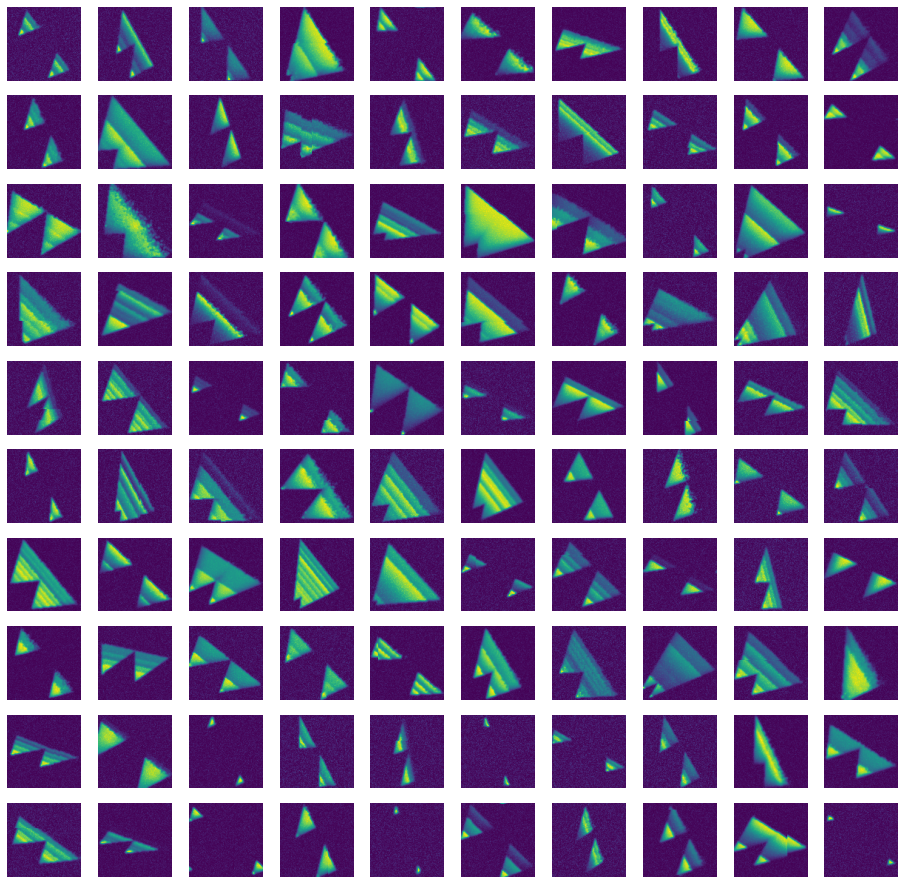

In [28]:
n_samples=100
samples=simulate_for_viola_jones(n_samples, sample_factors=sample_factors)


fig=plt.figure(figsize=(16,16))
for i, sample in enumerate(samples):
    plt.subplot(10, 10, i+1)
    plt.imshow(sample)
    plt.clim(0,1)
    plt.axis('off')
    
plt.show()